## 1. Importing the libraries.

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Mounted at /content/drive/


In [74]:
from datetime import datetime as dt
global start 
start = dt.now()

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np

import re
import string

from tqdm import tqdm
import os

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import accuracy_score
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 2. Loading the data and displaying the initial tables.

In [0]:
#Load the given dataframes.
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [0]:
#Display the contents of "train_data.csv"
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [0]:
#Display the contents of "resources.csv"
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


## 3. Merge the two dataframes based on ID

In [0]:
#Merging both the dataframes by their corresponding IDs
price_quantity_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_quantity_data, on='id', how='left')

#Remove the columns which are not needed anymore. Keeping ID for now.
project_data.drop(['Unnamed: 0', 'teacher_id', 'id'], axis=1, inplace=True)

project_data.head(3)

,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",,,My students need opportunities to practice beg...,0,0,154.60,23
1,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,,,My students need a projector to help with view...,7,1,299.00,1
2,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,,,"My students need shine guards, athletic socks,...",1,0,516.85,22


## 4. Basic information about the dataset.

In [0]:
print("Number of data points we have: ", project_data.shape[0])
print("Number of initial features we have:", project_data.shape[1]) 
print("\nLet's look at the all columns present in the dataset: \n",project_data.columns.values)

Number of data points we have:  109248
Number of initial features we have: 16

Let's look at the all columns present in the dataset: 
 ['teacher_prefix' 'school_state' 'project_submitted_datetime'
 'project_grade_category' 'project_subject_categories'
 'project_subject_subcategories' 'project_title' 'project_essay_1'
 'project_essay_2' 'project_essay_3' 'project_essay_4'
 'project_resource_summary' 'teacher_number_of_previously_posted_projects'
 'project_is_approved' 'price' 'quantity']


# 5. Data Pre-processing Section

In this section, we will pre-process all the data before using them to build Machine Learning models. The dataset has the following types of features:

<b>Categorical variables:</b>

1. teacher_prefix
2. school_state
3. project_grade_category
4. project_subject_categories
5. project_subject_subcategories

<b>Text data:</b>

1. project_essay_1
2. project_essay_2
3. project_essay_3
4. project_essay_4
5. project_title
6. project_resource_summary

<b>Numerical Data:</b>

1. teacher_number_of_previously_posted_projects
2. price
3. quantity

### 5.1 Utility functions for pre processing text datas and categories data

In [0]:
#Stopwords contains the list of commonly found english keywords. We will remove them from the text datas as part of the pre-processing of data.
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s", \
            't','u','v','w','x','y','z']

from tqdm import tqdm
def clean_subjects(input_values):
    '''This function will be used to pre process the two features -> "project_subject_categories" and 
    "project_subject_subcategories"'''
    processed_list = []
    for i in tqdm(input_values):
        temp = ""
        for j in i.split(','):
            if 'The' in j.split(): 
                j=j.replace('The','') 
            j = j.replace(' ','') 
            temp +=j.strip()+" "
            temp = temp.replace('&','_')
        processed_list.append(temp.strip())
    return processed_list

import re
def decontracted(phrase):
    """This function will be used to expand the de-contracted words"""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def process_text(list_of_sentences):
    """This function will be used to pre-process the text data"""
    preprocessed_texts = []
    for sentence in tqdm(list_of_sentences):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(word.lower() for word in sent.split() if word.lower() not in stopwords) #We will keep only those words in title which has a string length greater than one
        preprocessed_texts.append(sent.lower().strip())
    return preprocessed_texts

### 5.2 Pre-Processing the 'essays' data

In [0]:
#Merging the essays data into one single column for ease of processing.
project_data["essay"] = project_data["project_essay_1"].map(str) + \
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

preprocessed_essays = process_text(project_data["essay"].values)

#Add the pre-processed data into a new column.
project_data['clean_essays'] = preprocessed_essays

#Remove the columns which are already processed and are not needed anymore.
project_data.drop(['essay','project_essay_1','project_essay_2','project_essay_3','project_essay_4'], 
                  axis=1, inplace=True)

100%|██████████| 109248/109248 [02:00<00:00, 905.36it/s]


### 5.3 Pre-Processing the 'project_resource_summary' data

In [0]:
preprocessed_summary = process_text(project_data['project_resource_summary'].values)
project_data['clean_project_resource_summary'] = preprocessed_summary
project_data.drop(['project_resource_summary'], axis=1, inplace=True)

100%|██████████| 109248/109248 [00:12<00:00, 8621.78it/s]


### 5.4 Pre-Processing the 'project_title' data

In [0]:
preprocessed_titles = process_text(project_data['project_title'].values)
project_data['clean_project_title'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)

100%|██████████| 109248/109248 [00:05<00:00, 19912.64it/s]


### 5.5 Pre-Processing of 'project_subject_categories'

In [0]:
preprocessed_categories = clean_subjects(project_data['project_subject_categories'].values)

project_data['clean_categories'] = preprocessed_categories
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

100%|██████████| 109248/109248 [00:00<00:00, 302094.48it/s]


### 5.6 Pre-Processing of 'project_subject_subcategories'

In [0]:
preprocessed_subcategories = clean_subjects(project_data['project_subject_subcategories'].values)

project_data['clean_subcategories'] = preprocessed_subcategories
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

100%|██████████| 109248/109248 [00:00<00:00, 301790.06it/s]


### 5.7 Pre-Processing of 'project_grade_category'

In [0]:
project_data['project_grade_category'] = project_data['project_grade_category'].map(lambda x: x.replace(" ","_").replace("-","_"))

### 5.7 Designing a new feature called - Presence of numerical digits in project resources summary

In [0]:
def is_digit(sent):
    digits=re.findall('\d+', sent)
    if(len(digits) != 0 ):
        return 1
    else:
        return 0

project_data['presence_of_the_numerical_digits']=project_data['clean_project_resource_summary'].apply(is_digit)

### 5.8 Combining all text features into one single feature 'total_text'

In [0]:
project_data['total_text'] = project_data['clean_essays'].map(str) + " " + project_data['clean_project_resource_summary'].map(str) + " " + project_data['clean_project_title'].map(str)
project_data.drop(['clean_essays','clean_project_resource_summary','clean_project_title','project_submitted_datetime'], axis=1, inplace=True) #Remove not needed features

### 5.9 Replacing NAN values by empty strings 

In [0]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna(' ')

### 5.10 Display the processed dataframe and save it into a pandas CSV file.

In [0]:
#After pre-processing, we have 13 features. We will have one feature as our target variable and the rest of the columns as our independent features variables.
project_data.head(5)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,presence_of_the_numerical_digits,total_text
0,Mrs.,IN,Grades_PreK_2,0,0,154.60,23,Literacy_Language,ESL Literacy,0,students english learners working english seco...
1,Mr.,FL,Grades_6_8,7,1,299.00,1,History_Civics Health_Sports,Civics_Government TeamSports,0,students arrive school eager learn polite gene...
2,Ms.,AZ,Grades_6_8,1,0,516.85,22,Health_Sports,Health_Wellness TeamSports,0,true champions not always ones win guts mia ha...
3,Mrs.,KY,Grades_PreK_2,4,1,232.90,4,Literacy_Language Math_Science,Literacy Mathematics,0,work unique school filled esl english second l...
4,Mrs.,TX,Grades_PreK_2,1,1,67.98,4,Math_Science,Mathematics,0,second grade classroom next year made around 2...


In [0]:
DATADIR = "/content/drive/My Drive/Donors/"

In [0]:
#Save the processed dataset into a pandas CSV file.
project_data.to_csv("processed_data.csv", index=False)

In [2]:
project_data = pd.read_csv("processed_data.csv")

## 6. Splitting the original data into train and test data in 80:20 ratio.

In [3]:
#Taking the target and predictor variables into separate variables
y = project_data["project_is_approved"] #target variables
X = project_data.drop(['project_is_approved'], axis=1) #predictor variables

#Split the dataset into train and val dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.20, random_state=1, stratify=y_test)

#Display basic information after splitting the data
print("Number of points in train data: ",X_train.shape[0])
print("Number of points in validation data: ",X_val.shape[0])
print("Number of points in test data: ",X_test.shape[0])

Number of points in train data:  87398
Number of points in validation data:  17480
Number of points in test data:  4370


# Model-1

Build and Train deep neural network as shown below

<img src='LSTM_Image_2.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [ ]:
input_layer = Input(shape=(n,))
embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

## Total Text Data

### Build train and val data

In [4]:
#Get the total_text values in list
docs_text_train=list(X_train.total_text.values)
docs_text_val=list(X_val.total_text.values)
docs_text_test=list(X_test.total_text.values)
labels_train=np.array(y_train)
labels_val=np.array(y_val)
labels_test=np.array(y_test)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_text_train)

#Convert the texts to sequences using the tokenizer
sequences_text_train = tokens.texts_to_sequences(docs_text_train)
sequences_text_val = tokens.texts_to_sequences(docs_text_val)
sequences_text_test = tokens.texts_to_sequences(docs_text_test)
vocab_size_text = len(tokens.word_index) + 1

#Add padding
padded_text_train = pad_sequences(sequences_text_train, maxlen=300, padding='post')
padded_text_val = pad_sequences(sequences_text_val, maxlen=300, padding='post')
padded_text_test = pad_sequences(sequences_text_test, maxlen=300, padding='post')

In [5]:
#Load the whole embedding into memory
embeddings_index = dict()
file = open('glove.6B.300d.txt')
for line in file:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

#Create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size_text, 300))
for word, i in tqdm(tokens.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 

print(len(embedding_matrix[0]))

100%|██████████| 55638/55638 [00:00<00:00, 283171.75it/s]

Loaded 400000 word vectors.
300


In [6]:
#Get the flattened LSTM output for input text
input_layer_total_text = Input(shape=(300,), name = "total_text_sequence")
embedding_layer_total_text = Embedding(input_dim=vocab_size_text, output_dim=300, weights=[embedding_matrix], trainable=False)(input_layer_total_text)
lstm_total_text  = LSTM(16, activation="relu", return_sequences=True)(embedding_layer_total_text)
flatten_total_text = Flatten()(lstm_total_text)

Instructions for updating:
Colocations handled automatically by placer.


## Categorical data: school_state 

### Building train, test and validation data

In [7]:
#Get the school state values
docs_school_state_train=list(X_train.school_state.values)
docs_school_state_val=list(X_val.school_state.values)
docs_school_state_test=list(X_test.school_state.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_school_state_train)

#Convert the school_state to sequences using the tokenizer
sequences_school_train = np.array(tokens.texts_to_sequences(docs_school_state_train))
sequences_school_val = np.array(tokens.texts_to_sequences(docs_school_state_val))
sequences_school_test = np.array(tokens.texts_to_sequences(docs_school_state_test))
vocab_size_school_state = len(tokens.word_index) + 1

In [9]:
#Get the flattened output for school_state
input_layer_school_state = Input(shape=(1,), name = "encoded_school_state")
embedding_layer_school_state = Embedding(input_dim=vocab_size_school_state, output_dim=4, trainable=True)(input_layer_school_state)
flatten_school_state = Flatten()(embedding_layer_school_state)

## Categorical data: teacher_prefix 

### Building train, test and validation data

In [10]:
#Get the teacher_prefix values
docs_teacher_prefix_train=list(X_train.teacher_prefix.values)
docs_teacher_prefix_val=list(X_val.teacher_prefix.values)
docs_teacher_prefix_test=list(X_test.teacher_prefix.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_teacher_prefix_train)

#Convert the school_state to sequences using the tokenizer
sequences_teacher_prefix_train = np.array(tokens.texts_to_sequences(docs_teacher_prefix_train))
sequences_teacher_prefix_val = np.array(tokens.texts_to_sequences(docs_teacher_prefix_val))
sequences_teacher_prefix_test = np.array(tokens.texts_to_sequences(docs_teacher_prefix_test))
vocab_size_teacher_prefix = len(tokens.word_index) + 1

In [11]:
#Get the flattened output for teacher_prefix
input_layer_teacher_prefix = Input(shape=(1,), name = "teacher_prefix")
embedding_layer_teacher_prefix = Embedding(input_dim=vocab_size_teacher_prefix, output_dim=4, trainable=True)(input_layer_teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding_layer_teacher_prefix)

## Categorical data: project_grade_category 

### Building train, test and validation data

In [12]:
#Get the project_grade_category values
docs_project_grade_category_train=list(X_train.project_grade_category.values)
docs_project_grade_category_val=list(X_val.project_grade_category.values)
docs_project_grade_category_test=list(X_test.project_grade_category.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_project_grade_category_train)

#Convert the school_state to sequences using the tokenizer
sequences_project_grade_category_train = tokens.texts_to_sequences(docs_project_grade_category_train)
sequences_project_grade_category_val = tokens.texts_to_sequences(docs_project_grade_category_val)
sequences_project_grade_category_test = tokens.texts_to_sequences(docs_project_grade_category_test)
vocab_size_project_grade_category= len(tokens.word_index) + 1

#Add padding
padded_project_grade_category_train = pad_sequences(sequences_project_grade_category_train, maxlen=3, padding='post')
padded_project_grade_category_val = pad_sequences(sequences_project_grade_category_val, maxlen=3, padding='post')
padded_project_grade_category_test = pad_sequences(sequences_project_grade_category_test, maxlen=3, padding='post')

In [13]:
#Get the flattened output for project_grade_category
input_layer_project_grade = Input(shape=(3,), name = "project_grade_category")
embedding_layer_project_grade = Embedding(input_dim=vocab_size_project_grade_category, output_dim=4, trainable=True)(input_layer_project_grade)
flatten_project_grade = Flatten()(embedding_layer_project_grade)

## Categorical data: clean_categories

### Building train, test and validation data

In [14]:
#Get the clean_categories values
docs_clean_categories_train=list(X_train.clean_categories.values)
docs_clean_categories_val=list(X_val.clean_categories.values)
docs_clean_categories_test=list(X_test.clean_categories.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_clean_categories_train)

#Convert the school_state to sequences using the tokenizer
sequences_clean_categories_train = tokens.texts_to_sequences(docs_clean_categories_train)
sequences_clean_categories_val = tokens.texts_to_sequences(docs_clean_categories_val)
sequences_clean_categories_test = tokens.texts_to_sequences(docs_clean_categories_test)
vocab_size_clean_categories = len(tokens.word_index) + 1

#Add padding
padded_clean_categories_train = pad_sequences(sequences_clean_categories_train, maxlen=3, padding='post')
padded_clean_categories_val = pad_sequences(sequences_clean_categories_val, maxlen=3, padding='post')
padded_clean_categories_test = pad_sequences(sequences_clean_categories_test, maxlen=3, padding='post')


In [15]:
#Get the flattened output for clean_categories
input_layer_clean_categories = Input(shape=(3,), name = "clean_categories")
embedding_layer_clean_categories = Embedding(input_dim=vocab_size_clean_categories, output_dim=4, trainable=True)(input_layer_clean_categories)
flatten_clean_categories = Flatten()(embedding_layer_clean_categories)

## Categorical data: clean_subcategories

### Building train, test and validation data

In [16]:
#Get the clean_subcategories values
docs_clean_subcategories_train=list(X_train.clean_subcategories.values)
docs_clean_subcategories_val=list(X_val.clean_subcategories.values)
docs_clean_subcategories_test=list(X_test.clean_subcategories.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_clean_subcategories_train)

#Convert the school_state to sequences using the tokenizer
sequences_clean_subcategories_train = tokens.texts_to_sequences(docs_clean_subcategories_train)
sequences_clean_subcategories_val = tokens.texts_to_sequences(docs_clean_subcategories_val)
sequences_clean_subcategories_test = tokens.texts_to_sequences(docs_clean_subcategories_test)
vocab_size_clean_subcategories = len(tokens.word_index) + 1

padded_clean_subcategories_train = pad_sequences(sequences_clean_subcategories_train, maxlen=3, padding='post')
padded_clean_subcategories_val = pad_sequences(sequences_clean_subcategories_val, maxlen=3, padding='post')
padded_clean_subcategories_test = pad_sequences(sequences_clean_subcategories_test, maxlen=3, padding='post')

In [17]:
#Get the flattened output for clean_subcategories
input_layer_clean_subcategories = Input(shape=(3,), name = "clean_subcategories")
embedding_layer_clean_subcategories = Embedding(input_dim=vocab_size_clean_subcategories, output_dim=4, trainable=True)(input_layer_clean_subcategories)
flatten_clean_subcategories = Flatten()(embedding_layer_clean_subcategories)

## Numerical datas

In [18]:
from sklearn.preprocessing import Normalizer

def normalize_vars(data):
    """This function is used to normalize all the input datas between 0 and 1"""
    normalizer = Normalizer()
    data_normalized = normalizer.fit_transform(data.reshape(1, -1))
    return data_normalized, normalizer

## teacher_number_of_previously_posted_projects

### Building train, test and validation data

In [19]:
previous_projects_train = X_train.teacher_number_of_previously_posted_projects.values
previous_projects_val = X_val.teacher_number_of_previously_posted_projects.values
previous_projects_test = X_test.teacher_number_of_previously_posted_projects.values

norm_previous_projects_train, normalizer = normalize_vars(previous_projects_train.reshape(1,-1))
norm_previous_projects_val = normalizer.transform(previous_projects_val.reshape(1,-1))
norm_previous_projects_test = normalizer.transform(previous_projects_test.reshape(1,-1))

norm_previous_projects_train = norm_previous_projects_train.reshape(len(X_train),1)
norm_previous_projects_val = norm_previous_projects_val.reshape(len(X_val),1)
norm_previous_projects_test = norm_previous_projects_test.reshape(len(X_test),1)

In [20]:
#Input layer for teacher_number_of_previously_posted_projects
input_layer_previous_projects = Input(shape=(1,), name = "previous_projects")

## price

### Building train, test and validation data

In [21]:
price_train = X_train.price.values
price_val = X_val.price.values
price_test = X_test.price.values

norm_price_train, normalizer = normalize_vars(price_train.reshape(1,-1))
norm_price_val = normalizer.transform(price_val.reshape(1,-1))
norm_price_test = normalizer.transform(price_test.reshape(1,-1))

norm_price_train = norm_price_train.reshape(len(X_train),1)
norm_price_val = norm_price_val.reshape(len(X_val),1)
norm_price_test = norm_price_test.reshape(len(X_test),1)

In [22]:
#Input layer for price
input_layer_price = Input(shape=(1,), name = "price")

## quantity

### Building train and validation data

In [23]:
quantity_train = X_train.quantity.values
quantity_val = X_val.quantity.values
quantity_test = X_test.quantity.values

norm_quantity_train, normalizer = normalize_vars(quantity_train.reshape(1,-1))
norm_quantity_val = normalizer.transform(quantity_val.reshape(1,-1))
norm_quantity_test = normalizer.transform(quantity_test.reshape(1,-1))

norm_quantity_train = norm_quantity_train.reshape(len(X_train),1)
norm_quantity_val = norm_quantity_val.reshape(len(X_val),1)
norm_quantity_test = norm_quantity_test.reshape(len(X_test),1)

In [24]:
#Input layer for quantity
input_layer_quantity = Input(shape=(1,), name = "quantity")

### Concatenation of all the numerical features layers

In [25]:
numerical_features_layers_concat = concatenate([input_layer_previous_projects, input_layer_price, input_layer_quantity])
dense_layer_numerical = Dense(4, activation='relu',kernel_initializer='he_normal')(numerical_features_layers_concat)

### Concatenation of all the layers and building the final model

In [27]:
# Merge all the layers according to the architecture diagram
x = concatenate([flatten_total_text, flatten_teacher_prefix, flatten_school_state, flatten_project_grade, flatten_clean_categories, flatten_clean_subcategories, dense_layer_numerical])
x = Dense(8, activation='relu',kernel_initializer='he_normal', name='dense_layer_1')(x)
x = Dropout(0.3, name='dropout_1')(x)
x = Dense(4, activation='relu',kernel_initializer='he_normal',name='dense_layer_2')(x)
x = Dropout(0.3, name='dropout_2')(x)
output_layer = Dense(1, activation='sigmoid', name='output_layer')(x)

# Final model
model = Model(inputs=[input_layer_total_text,input_layer_teacher_prefix,input_layer_school_state,input_layer_project_grade,input_layer_clean_categories,
                      input_layer_clean_subcategories,input_layer_previous_projects,input_layer_price,input_layer_quantity], outputs=[output_layer])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
total_text_sequence (InputLayer (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     16691700    total_text_sequence[0][0]        
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
encoded_school_state (InputLaye (None, 1)            0                                            
__________________________________________________________________________________________________
project_gr

### Defining a custom metric AUC

In [28]:
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import roc_auc_score
#https://stackoverflow.com/questions/51922500/tf-metrics-auc-yielding-very-different-from-sklearn-metrics-roc-auc-score
def roc_auc(y_true, y_pred):
    auc = tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    #auc = tf.metrics.auc(y_true, y_pred, num_thresholds=200)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

### Defining a callbacks

In [29]:
from time import time
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping
tensorboard = TensorBoard(log_dir="logs/{}".format(time))
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [30]:
import gc
gc.collect()

60

### Compiling the final model

In [31]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[roc_auc])
model.fit(x=[padded_text_train,sequences_teacher_prefix_train,sequences_school_train,padded_project_grade_category_train,padded_clean_categories_train,padded_clean_subcategories_train,
             norm_previous_projects_train,norm_price_train,norm_quantity_train], 
          y=[labels_train],
          validation_data=([padded_text_val,sequences_teacher_prefix_val,sequences_school_val,padded_project_grade_category_val,padded_clean_categories_val,padded_clean_subcategories_val,
                            norm_previous_projects_val,norm_price_val,norm_quantity_val],[labels_val]),
          epochs=12, 
          batch_size=1024, 
          callbacks=[tensorboard])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Train on 87398 samples, validate on 17480 samples
Epoch 1/12
87398/87398 [==============================] - 130s 1ms/step - loss: 0.4693 - roc_auc: 0.5692 - val_loss: 0.4044 - val_roc_auc: 0.7076
Epoch 2/12
87398/87398 [==============================] - 130s 1ms/step - loss: 0.4371 - roc_auc: 0.6377 - val_loss: 0.4027 - val_roc_auc: 0.7211
Epoch 3/12
87398/87398 [==============================] - 129s 1ms/step - loss: 0.4274 - roc_auc: 0.6525 - val_loss: 0.3973 - val_roc_auc: 0.7302
Epoch 4/12
87398/87398 [======

In [32]:
!tensorboard --logdir=logs/

TensorBoard 1.13.1 at http://saugata:6006 (Press CTRL+C to quit)
^C


<img src='Model1.png'>

### Prediction on unseen test data

In [96]:
test_data=[padded_text_test,sequences_teacher_prefix_test,sequences_school_test,padded_project_grade_category_test,
                  padded_clean_categories_test,padded_clean_subcategories_test,norm_previous_projects_test,norm_price_test,norm_quantity_test]

#Test AUC
y_pred= model.predict(test_data)
print("AUC on unseen test data: ",roc_auc_score(y_test,y_pred))

#Test Accuracy
pred = [y_pred[i][0] for i in range(y_pred.shape[0])]
class_pred = [1 if i>0.5 else 0 for i in pred]
print("Accuracy on unseen test data: ",accuracy_score(y_test,class_pred))

AUC on unseen test data:  0.7164852592744682
Accuracy on unseen test data:  0.848512585812357


In [97]:
#Save model
model.save("model1.h5")

# Model-2

1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)

### TF-IDF Analysis

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Fit the TFIDF vectorizer to the train data
vect = TfidfVectorizer()
vect.fit_transform(X_train['total_text'])

#Get the features names and their corresponding IDF scores
words = vect.get_feature_names()
idf_words = vect.idf_

#Map the words and their idf_ scores in a disctionary
dict_word_idf_ = dict(zip(words, idf_words))

print("Total number of unique words present originally:", len(words))

Total number of unique words present originally: 55628


### Box-Plot Analysis

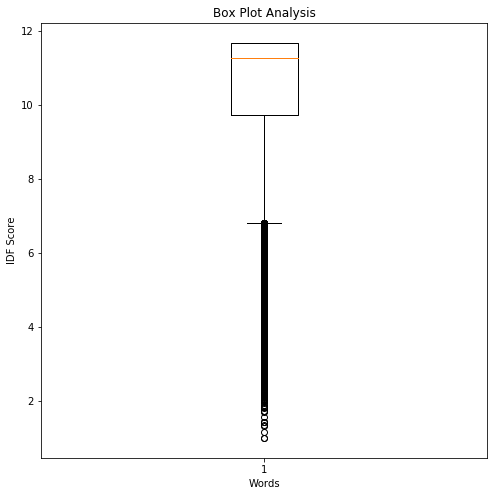

The lowest significant value of TF-IDF Scores:  6.5
The highest significant value of TF-IDF Scores:  11.685091939370627


In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.boxplot(idf_words)
plt.title('Box Plot Analysis')
plt.xlabel('Words')
plt.ylabel('IDF Score')
plt.show()

p_25th = 6.5
p_75th = np.percentile(idf_words,75)

print("The lowest significant value of TF-IDF Scores: ",p_25th)
print("The highest significant value of TF-IDF Scores: ",p_75th)

### Create a list of words to be removed

In [0]:
removed_wordlist = []
for word in list(dict_word_idf_.keys()):
    if(dict_word_idf_[word] < p_25th or dict_word_idf_[word] > p_75th):
        removed_wordlist.append(word)
    else:
        continue
        
print("Number of words to be removed: ",len(removed_wordlist))

Number of words to be removed:  2907


### Removing words from the train and val data which falls outside the threshold range

In [0]:
def remove_from_text(list_of_sentences):
    """This function will be used to remove words from text data"""
    processed_text = []
    for sentence in tqdm(list_of_sentences):
        sent = ' '.join(word for word in sentence.split() if word not in removed_wordlist) #We will keep only those words in title which has a string length greater than one
        processed_text.append(sent)
    return processed_text

X_train['total_text'] = remove_from_text(X_train.total_text.values)
X_val['total_text'] = remove_from_text(X_val.total_text.values)
X_test['total_text'] = remove_from_text(X_test.total_text.values)

100%|██████████| 21850/21850 [02:11<00:00, 167.46it/s]


In [0]:
X_train.to_csv("X_train_removed.csv", index=False)
X_val.to_csv("X_val_removed.csv", index=False)
X_test.to_csv("X_test_removed.csv", index=False)

In [0]:
X_train = pd.read_csv("X_train_removed.csv")
X_val = pd.read_csv("X_val_removed.csv")
X_test = pd.read_csv("X_test_removed.csv")

## Total Text Data

### Building train, test and validation data

In [0]:
#Get the total_text values in list
docs_text_train=list(X_train.total_text.values)
docs_text_val=list(X_val.total_text.values)
docs_text_test=list(X_test.total_text.values)
labels_train=np.array(y_train)
labels_val=np.array(y_val)
labels_test=np.array(y_test)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_text_train)

#Convert the texts to sequences using the tokenizer
sequences_text_train = tokens.texts_to_sequences(docs_text_train)
sequences_text_val = tokens.texts_to_sequences(docs_text_val)
sequences_text_test = tokens.texts_to_sequences(docs_text_test)
vocab_size_text = len(tokens.word_index) + 1

#Add padding
padded_text_train = pad_sequences(sequences_text_train, maxlen=300, padding='post')
padded_text_val = pad_sequences(sequences_text_val, maxlen=300, padding='post')
padded_text_test = pad_sequences(sequences_text_test, maxlen=300, padding='post')

In [0]:
#Load the whole embedding into memory
embeddings_index = dict()
file = open('glove.6B.300d.txt')
for line in file:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

#Create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size_text, 300))
for word, i in tqdm(tokens.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 

print(len(embedding_matrix[0]))

 42%|████▏     | 23363/55638 [00:00<00:00, 233627.44it/s]

Loaded 400000 word vectors.


100%|██████████| 55638/55638 [00:00<00:00, 271418.24it/s]

300


In [0]:
#Get the flattened LSTM output for input text
input_layer_total_text = Input(shape=(300,), name = "total_text_sequence")
embedding_layer_total_text = Embedding(input_dim=vocab_size_text, output_dim=300, weights=[embedding_matrix], trainable=False)(input_layer_total_text)
lstm_total_text  = LSTM(16, activation="relu", return_sequences=True)(embedding_layer_total_text)
flatten_total_text = Flatten()(lstm_total_text)

Instructions for updating:
Colocations handled automatically by placer.


## Categorical data: school_state 

### Building train, test and validation data

In [0]:
#Get the school state values
docs_school_state_train=list(X_train.school_state.values)
docs_school_state_val=list(X_val.school_state.values)
docs_school_state_test=list(X_test.school_state.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_school_state_train)

#Convert the school_state to sequences using the tokenizer
sequences_school_train = np.array(tokens.texts_to_sequences(docs_school_state_train))
sequences_school_val = np.array(tokens.texts_to_sequences(docs_school_state_val))
sequences_school_test = np.array(tokens.texts_to_sequences(docs_school_state_test))
vocab_size_school_state = len(tokens.word_index) + 1

In [0]:
#Get the flattened output for school_state
input_layer_school_state = Input(shape=(1,), name = "encoded_school_state")
embedding_layer_school_state = Embedding(input_dim=vocab_size_school_state, output_dim=4, trainable=True)(input_layer_school_state)
flatten_school_state = Flatten()(embedding_layer_school_state)

## Categorical data: teacher_prefix 

### Building train, test and validation data

In [0]:
#Get the teacher_prefix values
docs_teacher_prefix_train=list(X_train.teacher_prefix.values)
docs_teacher_prefix_val=list(X_val.teacher_prefix.values)
docs_teacher_prefix_test=list(X_test.teacher_prefix.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_teacher_prefix_train)

#Convert the school_state to sequences using the tokenizer
sequences_teacher_prefix_train = np.array(tokens.texts_to_sequences(docs_teacher_prefix_train))
sequences_teacher_prefix_val = np.array(tokens.texts_to_sequences(docs_teacher_prefix_val))
sequences_teacher_prefix_test = np.array(tokens.texts_to_sequences(docs_teacher_prefix_test))
vocab_size_teacher_prefix = len(tokens.word_index) + 1

In [0]:
#Get the flattened output for teacher_prefix
input_layer_teacher_prefix = Input(shape=(1,), name = "teacher_prefix")
embedding_layer_teacher_prefix = Embedding(input_dim=vocab_size_teacher_prefix, output_dim=4, trainable=True)(input_layer_teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding_layer_teacher_prefix)

## Categorical data: project_grade_category 

### Building train, test and validation data

In [0]:
#Get the project_grade_category values
docs_project_grade_category_train=list(X_train.project_grade_category.values)
docs_project_grade_category_val=list(X_val.project_grade_category.values)
docs_project_grade_category_test=list(X_test.project_grade_category.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_project_grade_category_train)

#Convert the school_state to sequences using the tokenizer
sequences_project_grade_category_train = tokens.texts_to_sequences(docs_project_grade_category_train)
sequences_project_grade_category_val = tokens.texts_to_sequences(docs_project_grade_category_val)
sequences_project_grade_category_test = tokens.texts_to_sequences(docs_project_grade_category_test)
vocab_size_project_grade_category= len(tokens.word_index) + 1

#Add padding
padded_project_grade_category_train = pad_sequences(sequences_project_grade_category_train, maxlen=3, padding='post')
padded_project_grade_category_val = pad_sequences(sequences_project_grade_category_val, maxlen=3, padding='post')
padded_project_grade_category_test = pad_sequences(sequences_project_grade_category_test, maxlen=3, padding='post')

In [0]:
#Get the flattened output for project_grade_category
input_layer_project_grade = Input(shape=(3,), name = "project_grade_category")
embedding_layer_project_grade = Embedding(input_dim=vocab_size_project_grade_category, output_dim=4, trainable=True)(input_layer_project_grade)
flatten_project_grade = Flatten()(embedding_layer_project_grade)

## Categorical data: clean_categories

### Building train, test and validation data

In [0]:
#Get the clean_categories values
docs_clean_categories_train=list(X_train.clean_categories.values)
docs_clean_categories_val=list(X_val.clean_categories.values)
docs_clean_categories_test=list(X_test.clean_categories.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_clean_categories_train)

#Convert the school_state to sequences using the tokenizer
sequences_clean_categories_train = tokens.texts_to_sequences(docs_clean_categories_train)
sequences_clean_categories_val = tokens.texts_to_sequences(docs_clean_categories_val)
sequences_clean_categories_test = tokens.texts_to_sequences(docs_clean_categories_test)
vocab_size_clean_categories = len(tokens.word_index) + 1

#Add padding
padded_clean_categories_train = pad_sequences(sequences_clean_categories_train, maxlen=3, padding='post')
padded_clean_categories_val = pad_sequences(sequences_clean_categories_val, maxlen=3, padding='post')
padded_clean_categories_test = pad_sequences(sequences_clean_categories_test, maxlen=3, padding='post')


In [0]:
#Get the flattened output for clean_categories
input_layer_clean_categories = Input(shape=(3,), name = "clean_categories")
embedding_layer_clean_categories = Embedding(input_dim=vocab_size_clean_categories, output_dim=4, trainable=True)(input_layer_clean_categories)
flatten_clean_categories = Flatten()(embedding_layer_clean_categories)

## Categorical data: clean_subcategories

### Building train, test and validation data

In [0]:
#Get the clean_subcategories values
docs_clean_subcategories_train=list(X_train.clean_subcategories.values)
docs_clean_subcategories_val=list(X_val.clean_subcategories.values)
docs_clean_subcategories_test=list(X_test.clean_subcategories.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_clean_subcategories_train)

#Convert the school_state to sequences using the tokenizer
sequences_clean_subcategories_train = tokens.texts_to_sequences(docs_clean_subcategories_train)
sequences_clean_subcategories_val = tokens.texts_to_sequences(docs_clean_subcategories_val)
sequences_clean_subcategories_test = tokens.texts_to_sequences(docs_clean_subcategories_test)
vocab_size_clean_subcategories = len(tokens.word_index) + 1

padded_clean_subcategories_train = pad_sequences(sequences_clean_subcategories_train, maxlen=3, padding='post')
padded_clean_subcategories_val = pad_sequences(sequences_clean_subcategories_val, maxlen=3, padding='post')
padded_clean_subcategories_test = pad_sequences(sequences_clean_subcategories_test, maxlen=3, padding='post')

In [0]:
#Get the flattened output for clean_subcategories
input_layer_clean_subcategories = Input(shape=(3,), name = "clean_subcategories")
embedding_layer_clean_subcategories = Embedding(input_dim=vocab_size_clean_subcategories, output_dim=4, trainable=True)(input_layer_clean_subcategories)
flatten_clean_subcategories = Flatten()(embedding_layer_clean_subcategories)

## teacher_number_of_previously_posted_projects

### Building train, test and validation data

In [0]:
previous_projects_train = X_train.teacher_number_of_previously_posted_projects.values
previous_projects_val = X_val.teacher_number_of_previously_posted_projects.values
previous_projects_test = X_test.teacher_number_of_previously_posted_projects.values

norm_previous_projects_train, normalizer = normalize_vars(previous_projects_train.reshape(1,-1))
norm_previous_projects_val = normalizer.transform(previous_projects_val.reshape(1,-1))
norm_previous_projects_test = normalizer.transform(previous_projects_test.reshape(1,-1))

norm_previous_projects_train = norm_previous_projects_train.reshape(len(X_train),1)
norm_previous_projects_val = norm_previous_projects_val.reshape(len(X_val),1)
norm_previous_projects_test = norm_previous_projects_test.reshape(len(X_test),1)

In [0]:
#Input layer for teacher_number_of_previously_posted_projects
input_layer_previous_projects = Input(shape=(1,), name = "previous_projects")

## price

### Building train, test and validation data

In [0]:
price_train = X_train.price.values
price_val = X_val.price.values
price_test = X_test.price.values

norm_price_train, normalizer = normalize_vars(price_train.reshape(1,-1))
norm_price_val = normalizer.transform(price_val.reshape(1,-1))
norm_price_test = normalizer.transform(price_test.reshape(1,-1))

norm_price_train = norm_price_train.reshape(len(X_train),1)
norm_price_val = norm_price_val.reshape(len(X_val),1)
norm_price_test = norm_price_test.reshape(len(X_test),1)

In [0]:
#Input layer for price
input_layer_price = Input(shape=(1,), name = "price")

## quantity

### Building train and validation data

In [0]:
quantity_train = X_train.quantity.values
quantity_val = X_val.quantity.values
quantity_test = X_test.quantity.values

norm_quantity_train, normalizer = normalize_vars(quantity_train.reshape(1,-1))
norm_quantity_val = normalizer.transform(quantity_val.reshape(1,-1))
norm_quantity_test = normalizer.transform(quantity_test.reshape(1,-1))

norm_quantity_train = norm_quantity_train.reshape(len(X_train),1)
norm_quantity_val = norm_quantity_val.reshape(len(X_val),1)
norm_quantity_test = norm_quantity_test.reshape(len(X_test),1)

In [0]:
#Input layer for quantity
input_layer_quantity = Input(shape=(1,), name = "quantity")

### Concatenation of the numerical layers

In [0]:
numerical_features_layers_concat = concatenate([input_layer_previous_projects, input_layer_price, input_layer_quantity])
dense_layer_numerical = Dense(4, activation='relu',kernel_initializer='he_normal')(numerical_features_layers_concat)

### Concatenation of all the layers and building the final model

In [0]:
del( X_train, X_val, y_train, y_val, X, y, project_data, file, embeddings_index, coefs)

In [0]:
# Merge all the layers according to the architecture diagram
x = concatenate([flatten_total_text, flatten_teacher_prefix, flatten_school_state, flatten_project_grade, flatten_clean_categories, flatten_clean_subcategories, dense_layer_numerical])
x = Dense(8, activation='relu',kernel_initializer='he_normal', name='dense_layer_1')(x)
x = Dropout(0.4, name='dropout_1')(x)
x = Dense(4, activation='relu',kernel_initializer='he_normal',name='dense_layer_2')(x)
x = Dropout(0.4, name='dropout_2')(x)
output_layer = Dense(1, activation='sigmoid', name='output_layer')(x)

# Final model 2
model = Model(inputs=[input_layer_total_text,input_layer_teacher_prefix,input_layer_school_state,input_layer_project_grade,input_layer_clean_categories,
                      input_layer_clean_subcategories,input_layer_previous_projects,input_layer_price,input_layer_quantity], outputs=[output_layer])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
total_text_sequence (InputLayer (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     16691700    total_text_sequence[0][0]        
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
encoded_school_state (InputLaye (None, 1)            0                                            
__________________________________________________________________________________________________
project_gr

### Compiling the final model

In [0]:
import gc
gc.collect()

0

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[roc_auc])
model.fit(x=[padded_text_train,sequences_teacher_prefix_train,sequences_school_train,padded_project_grade_category_train,padded_clean_categories_train,padded_clean_subcategories_train,
             norm_previous_projects_train,norm_price_train,norm_quantity_train], 
          y=[labels_train],
          validation_data=([padded_text_val,sequences_teacher_prefix_val,sequences_school_val,padded_project_grade_category_val,padded_clean_categories_val,padded_clean_subcategories_val,
                            norm_previous_projects_val,norm_price_val,norm_quantity_val],[labels_val]),
          epochs=30, 
          batch_size=1024, 
          callbacks=[tensorboard])

Train on 87398 samples, validate on 21850 samples
Epoch 1/50
87398/87398 [==============================] - 129s 1ms/step - loss: 0.4946 - roc_auc: 0.5318 - val_loss: 0.4012 - val_roc_auc: 0.5635
Epoch 2/50
87398/87398 [==============================] - 127s 1ms/step - loss: 0.4578 - roc_auc: 0.5802 - val_loss: 0.3953 - val_roc_auc: 0.5931
Epoch 3/50
87398/87398 [==============================] - 127s 1ms/step - loss: 0.4391 - roc_auc: 0.6024 - val_loss: 0.3973 - val_roc_auc: 0.6093
Epoch 4/50
87398/87398 [==============================] - 127s 1ms/step - loss: 0.4268 - roc_auc: 0.6152 - val_loss: 0.3927 - val_roc_auc: 0.6198
Epoch 5/50
87398/87398 [==============================] - 127s 1ms/step - loss: 0.4192 - roc_auc: 0.6240 - val_loss: 0.3882 - val_roc_auc: 0.6276
Epoch 6/50
87398/87398 [==============================] - 127s 1ms/step - loss: 0.4151 - roc_auc: 0.6307 - val_loss: 0.3861 - val_roc_auc: 0.6338
Epoch 7/50
87398/87398 [==============================] - 127s 1ms/step - 

In [0]:
!tensorboard --logdir=logs/

TensorBoard 1.13.1 at http://saugata:6006 (Press CTRL+C to quit)
^C


<img src='Model2.png'>

### Prediction on unseen test data

In [91]:
test_data=[padded_text_test,sequences_teacher_prefix_test,sequences_school_test,padded_project_grade_category_test,
                  padded_clean_categories_test,padded_clean_subcategories_test,norm_previous_projects_test,norm_price_test,norm_quantity_test]

#Test AUC
y_pred= model.predict(test_data)
print("AUC on unseen test data: ",roc_auc_score(y_test,y_pred))

#Test Accuracy
pred = [y_pred[i][0] for i in range(y_pred.shape[0])]
class_pred = [1 if i>0.5 else 0 for i in pred]
print("Accuracy on unseen test data: ",accuracy_score(y_test,class_pred))

AUC on unseen test data:  0.7164852592744682
Accuracy on unseen test data:  0.848512585812357


In [92]:
#Save model
model.save("model1.h5")

# Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

## 1. Load the data

In [0]:
project_data = pd.read_csv("processed_data.csv")

## 2. Splitting the original data into train and test data in 80:20 ratio.

In [42]:
#Taking the target and predictor variables into separate variables
y = project_data["project_is_approved"] #target variables
X = project_data.drop(['project_is_approved'], axis=1) #predictor variables

#Split the dataset into train and val dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.20, random_state=1, stratify=y_test)

#Display basic information after splitting the data
print("Number of points in train data: ",X_train.shape[0])
print("Number of points in validation data: ",X_val.shape[0])
print("Number of points in test data: ",X_test.shape[0])

Number of points in train data:  87398
Number of points in validation data:  17480
Number of points in test data:  4370


## 3. Tokenizing Total Text Data

### Building train, test and validation data

In [0]:
#Get the total_text values in list
docs_text_train=list(X_train.total_text.values)
docs_text_val=list(X_val.total_text.values)
docs_text_test=list(X_test.total_text.values)
labels_train=np.array(y_train)
labels_val=np.array(y_val)
labels_test=np.array(y_test)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_text_train)

#Convert the texts to sequences using the tokenizer
sequences_text_train = tokens.texts_to_sequences(docs_text_train)
sequences_text_val = tokens.texts_to_sequences(docs_text_val)
sequences_text_test = tokens.texts_to_sequences(docs_text_test)
vocab_size_text = len(tokens.word_index) + 1

#Add padding
padded_text_train = pad_sequences(sequences_text_train, maxlen=300, padding='post')
padded_text_val = pad_sequences(sequences_text_val, maxlen=300, padding='post')
padded_text_test = pad_sequences(sequences_text_test, maxlen=300, padding='post')

In [0]:
#Load the whole embedding into memory
embeddings_index = dict()
file = open('glove.6B.300d.txt')
for line in file:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

#Create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size_text, 300))
for word, i in tqdm(tokens.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector #embedding_matrix.shape: (9049, 300)

print(len(embedding_matrix[0]))

100%|██████████| 55638/55638 [00:00<00:00, 302291.89it/s]

Loaded 400000 word vectors.
300


In [0]:
#Get the flattened LSTM output for input text
input_layer_total_text = Input(shape=(300,), name = "total_text_sequence")
embedding_layer_total_text = Embedding(input_dim=vocab_size_text, output_dim=300, weights=[embedding_matrix], trainable=False)(input_layer_total_text)
lstm_total_text  = LSTM(16, activation="relu", return_sequences=True)(embedding_layer_total_text)
flatten_lstm_out = Flatten()(lstm_total_text)

## 4. One hot encoding categorical features

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
#School state
encoder=OneHotEncoder().fit(X_train['school_state'].values.reshape(-1,1))
enc_school_state_train=encoder.transform(X_train['school_state'].values.reshape(-1,1))
enc_school_state_val=encoder.transform(X_val['school_state'].values.reshape(-1, 1))
enc_school_state_test=encoder.transform(X_test['school_state'].values.reshape(-1, 1))

#Teacher prefix
encoder=OneHotEncoder().fit(X_train['teacher_prefix'].values.reshape(-1,1))
enc_teacher_prefix_train=encoder.transform(X_train['teacher_prefix'].values.reshape(-1,1))
enc_teacher_prefix_val=encoder.transform(X_val['teacher_prefix'].values.reshape(-1, 1))
enc_teacher_prefix_test=encoder.transform(X_test['teacher_prefix'].values.reshape(-1, 1))

#project_grade_category
encoder=OneHotEncoder().fit(X_train['project_grade_category'].values.reshape(-1,1))
enc_project_grade_category_train=encoder.transform(X_train['project_grade_category'].values.reshape(-1,1))
enc_project_grade_category_val=encoder.transform(X_val['project_grade_category'].values.reshape(-1, 1))
enc_project_grade_category_test=encoder.transform(X_test['project_grade_category'].values.reshape(-1, 1))

#clean_categories
encoder=CountVectorizer(binary=True).fit(X_train['clean_categories'])
enc_clean_categories_category_train=encoder.transform(X_train['clean_categories'])
enc_clean_categories_category_val=encoder.transform(X_val['clean_categories'])
enc_clean_categories_category_test=encoder.transform(X_test['clean_categories'])

#clean_subcategories
encoder=CountVectorizer(binary=True).fit(X_train['clean_subcategories'])
enc_clean_subcategories_train=encoder.transform(X_train['clean_subcategories'])
enc_clean_subcategories_val=encoder.transform(X_val['clean_subcategories'])
enc_clean_subcategories_test=encoder.transform(X_test['clean_subcategories'])

## 5. Normalizing numerical data

In [0]:
#teacher_number_of_previously_posted_projects
previous_projects_train = X_train.teacher_number_of_previously_posted_projects.values
previous_projects_val = X_val.teacher_number_of_previously_posted_projects.values
previous_projects_test = X_test.teacher_number_of_previously_posted_projects.values

norm_previous_projects_train, normalizer = normalize_vars(previous_projects_train.reshape(1,-1))
norm_previous_projects_val = normalizer.transform(previous_projects_val.reshape(1,-1))
norm_previous_projects_test = normalizer.transform(previous_projects_test.reshape(1,-1))

norm_previous_projects_train = norm_previous_projects_train.reshape(len(X_train),1)
norm_previous_projects_val = norm_previous_projects_val.reshape(len(X_val),1)
norm_previous_projects_test = norm_previous_projects_test.reshape(len(X_test),1)

#price
price_train = X_train.price.values
price_val = X_val.price.values
price_test = X_test.price.values

norm_price_train, normalizer = normalize_vars(price_train.reshape(1,-1))
norm_price_val = normalizer.transform(price_val.reshape(1,-1))
norm_price_test = normalizer.transform(price_test.reshape(1,-1))

norm_price_train = norm_price_train.reshape(len(X_train),1)
norm_price_val = norm_price_val.reshape(len(X_val),1)
norm_price_test = norm_price_test.reshape(len(X_test),1)

#quantity
quantity_train = X_train.quantity.values
quantity_val = X_val.quantity.values
quantity_test = X_test.quantity.values

norm_quantity_train, normalizer = normalize_vars(quantity_train.reshape(1,-1))
norm_quantity_val = normalizer.transform(quantity_val.reshape(1,-1))
norm_quantity_test = normalizer.transform(quantity_test.reshape(1,-1))

norm_quantity_train = norm_quantity_train.reshape(len(X_train),1)
norm_quantity_val = norm_quantity_val.reshape(len(X_val),1)
norm_quantity_test = norm_quantity_test.reshape(len(X_test),1)

## 5. Stacking the numerical and categorical vectors

In [0]:
stacked_vectors_train = hstack((enc_school_state_train,enc_teacher_prefix_train,enc_project_grade_category_train,enc_clean_categories_category_train,enc_clean_subcategories_train,
                                norm_previous_projects_train,norm_price_train,norm_quantity_train))

stacked_vectors_val = hstack((enc_school_state_val,enc_teacher_prefix_val,enc_project_grade_category_val,enc_clean_categories_category_val,enc_clean_subcategories_val,
                                norm_previous_projects_val,norm_price_val,norm_quantity_val))

stacked_vectors_test = hstack((enc_school_state_test,enc_teacher_prefix_test,enc_project_grade_category_test,enc_clean_categories_category_test,enc_clean_subcategories_test,
                                norm_previous_projects_test,norm_price_test,norm_quantity_test))

In [0]:
encoded_df_train = np.expand_dims(pd.DataFrame(stacked_vectors_train.todense()), axis=2)
encoded_df_val = np.expand_dims(pd.DataFrame(stacked_vectors_val.todense()), axis=2)
encoded_df_test = np.expand_dims(pd.DataFrame(stacked_vectors_test.todense()), axis=2)

## 6. Defining the model architecture

In [0]:
from keras.layers import Conv1D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model

conv_input = Input(shape=(stacked_vectors_train.shape[1],1), name="non_text_data_layer")
x = Conv1D(filters=8, kernel_size=4, activation='relu', kernel_initializer='he_normal',name='conv_layer_1')(conv_input)
x = Conv1D(filters=8, kernel_size=4, activation='relu', kernel_initializer='he_normal',name='conv_layer_2')(x)
flatten_conv_output = Flatten()(x) 

In [0]:
del( X_train, X_val, y_train, y_val, X, y, project_data, file, embeddings_index, coefs, stacked_vectors_val, stacked_vectors_train)

In [0]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout

x = concatenate([flatten_lstm_out, flatten_conv_output])

x = Dense(32, activation='relu', kernel_initializer='he_normal',name='dense_layer_1')(x)
x = Dropout(0.6)(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal',name='dense_layer_2')(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal',name='dense_layer_3')(x)

output = Dense(1, activation='sigmoid', name='output')(x)

model = Model(inputs=[input_layer_total_text,conv_input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
total_text_sequence (InputLayer (None, 300)          0                                            
__________________________________________________________________________________________________
non_text_data_layer (InputLayer (None, 102, 1)       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 300)     16691700    total_text_sequence[0][0]        
__________________________________________________________________________________________________
conv_layer_1 (Conv1D)           (None, 99, 8)        40          non_text_data_layer[0][0]        
__________________________________________________________________________________________________
lstm_2 (LS

## 7. Compiling the final model

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[roc_auc])
model.fit(x=[padded_text_train, encoded_df_train], 
          y=[labels_train],
          epochs=50, 
          batch_size=1024,
          validation_data=([padded_text_val, encoded_df_val],[labels_val]),
          callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 87398 samples, validate on 21850 samples
Epoch 1/50
87398/87398 [==============================] - 131s 2ms/step - loss: 0.4499 - roc_auc: 0.5471 - val_loss: 0.4042 - val_roc_auc: 0.5973
Epoch 2/50
87398/87398 [==============================] - 129s 1ms/step - loss: 0.4035 - roc_auc: 0.6227 - val_loss: 0.4304 - val_roc_auc: 0.6372
Epoch 3/50
87398/87398 [==============================] - 129s 1ms/step - loss: 0.3943 - roc_auc: 0.6473 - val_loss: 0.4397 - val_roc_auc: 0.6553
Epoch 4/50
87398/87398 [==============================] - 129s 1ms/step - loss: 0.3882 - roc_auc: 0.6615 - val_loss: 0.4159 - val_roc_auc: 0.6684
Epoch 5/50
87398/87398 [==============================] - 129s 1ms/step - loss: 0.3830 - roc_auc: 0.6738 - val_loss: 0.4171 - val_roc_auc: 0.6791
Epoch 6/50
87398/87398 [======================

In [0]:
!tensorboard --logdir=logs/

TensorBoard 1.13.1 at http://saugata:6006 (Press CTRL+C to quit)
^C


<img src='Model3.png'>

# Model comparison

In [0]:
from prettytable import PrettyTable

table =PrettyTable()
table.field_names = ["Model No", "Trained for Epochs", "Train ROC-AUC", "Validation ROC-AUC", "Test ROC-AUC"]
table.add_row(["Model 1",40,0.7344,0.7352])
table.add_row(["Model 2",50,0.7774,0.7781])
table.add_row(["Model 3",50,0.7947,0.7951])
print(table)

+----------+--------------------+---------------+--------------+
| Model No | Trained for Epochs | Train ROC-AUC | Test ROC-AUC |
+----------+--------------------+---------------+--------------+
| Model 1  |         40         |     0.7344    |    0.7352    |
| Model 2  |         50         |     0.7774    |    0.7781    |
| Model 3  |         50         |     0.7947    |    0.7951    |
+----------+--------------------+---------------+--------------+


# Brief Summary:

1. Amongst all the three models, the 3rd model with 1D CNN layers seems to perform the best as we have got the maximum value of ROC-AUC for it.
2. I first tried without proper weight initialization in the hidden layers, but this was resulting in a massive overfitting and the models were trained way-wardly. The test roc auc was always 7-10% more than the validation roc-auc.There was also an issue of exploding gradients after training the models for longer epochs. The problem of exploding gradients seems to have been resolved on using proper initialization techniques.
3. Using RSM Prop with proper weight initialization was also resulting in exploding gradients for Model 1. Changing the optimizer to adam has changed this problem.
4. Got the loss curves and score curve using Tensorboard. 
5. Used a custome metric function for training the model with a custom roc-auc score.
6. For TFIDF analysis, I first tried with the 25 percentile threshold for tfidf scores and the model performed very poorly despiting trying my best to optimize it. The lowest threshold I have considered for this assignment is 6.5 approximately.
7. By far, Model 2 has given us the best curve in terms of vaidation loss. The curve shows no overfitting, and we also have obtained close to 0.78 AUC score.
8. Model 3 has given us the best value of ROC-AUC - just under 0.80 for training the model for 50 epochs. 
9. Used this blog as a reference for doing this assignment: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/